In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [3]:
print("Using device:", device)

Using device: cuda:5


In [4]:
train_dir = "data/train_data"
val_dir = "data/validation_data"
test_dir = "data/test_data"
csv_path = "final data.csv"

In [5]:
df_labels = pd.read_csv(csv_path)
print(df_labels.head())

        Image Index  Finding Labels  Label
0  00017750_004.png  ['No Finding']      0
1  00017750_005.png  ['No Finding']      0
2  00017750_006.png  ['No Finding']      0
3  00017751_002.png  ['No Finding']      0
4  00017751_003.png  ['No Finding']      0


In [6]:
def get_filenames_and_labels(df, folder):
    filenames = df['Image Index'].tolist()
    labels = df['Label'].tolist()
    paths = [os.path.join(folder, fname) for fname in filenames]
    return paths, labels

In [7]:
train_paths, train_labels = get_filenames_and_labels(
    df_labels[df_labels['Image Index'].isin(os.listdir(train_dir))], train_dir)
val_paths, val_labels = get_filenames_and_labels(
    df_labels[df_labels['Image Index'].isin(os.listdir(val_dir))], val_dir)
test_paths, test_labels = get_filenames_and_labels(
    df_labels[df_labels['Image Index'].isin(os.listdir(test_dir))], test_dir)

In [8]:
img_height, img_width = 256, 256
batch_size = 32

In [9]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("L")),          # Ensure image is grayscale
    transforms.Lambda(lambda img: img.convert("RGB")),        # Convert grayscale to RGB (3 channels)
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),                                    # Converts to tensor and scales to [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5],                 # Normalize to [-1,1]
                         std=[0.5, 0.5, 0.5])
])

In [10]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


In [11]:
if cuda_available:
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    # Print the current device index
    print(f"Current device index: {torch.cuda.current_device()}")
    # Print the name of the first GPU
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Number of GPUs: 32
Current device index: 0
GPU Name: NVIDIA A16


In [12]:
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert("L").convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        one_hot_label = torch.zeros(2)
        one_hot_label[label] = 1.0
        return image, one_hot_label

In [13]:
train_dataset = ChestXrayDataset(train_paths, train_labels, transform=transform)
val_dataset = ChestXrayDataset(val_paths, val_labels, transform=transform)
test_dataset = ChestXrayDataset(test_paths, test_labels, transform=transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [15]:
def show_images(images, labels):
    grid_img = torchvision.utils.make_grid(images, nrow=3, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Sample Images")
    plt.axis('off')
    plt.show()

Images shape: torch.Size([32, 3, 256, 256])


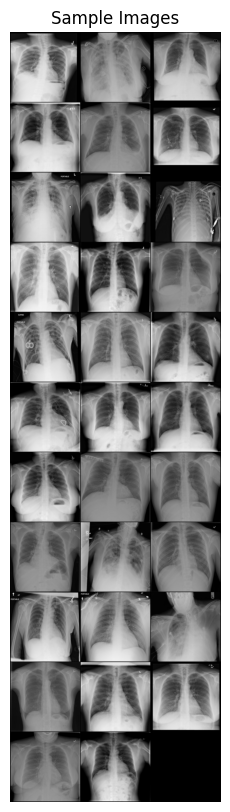

In [16]:
for images, labels in train_loader:
    print("Images shape:", images.shape)
    show_images(images, labels)
    break

In [69]:
latent_dim = 100         # Size of the random noise vector
image_channels = 3       # RGB images
hidden_dim = 64          # Base feature map size
image_size = 256         # Your image size
batch_size = 32          # Matches your DataLoader
lr_g = 0.0002  # Generator learning rate
lr_d = 0.0001            # Learning rate discriminator
beta1 = 0.5              # Adam optimizer beta1
epochs = 20

In [62]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_dim * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 16, hidden_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim // 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim // 2, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [63]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, hidden_dim, 4, 2, 1, bias=False),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 16, 1, 8, 1, 0, bias=False),  # Fixed to 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [64]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [71]:
lr_g = 0.0002  # Generator learning rate
lr_d = 0.0001  # Discriminator learning rate (half of generator)
g_optimizer = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

In [66]:
criterion = nn.BCELoss()

In [67]:
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

In [76]:
real_images_for_metrics = []
fake_images_for_metrics = []
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_label = torch.ones(batch_size, 1, 1, 1, device=device)
        fake_label = torch.zeros(batch_size, 1, 1, 1, device=device)
    
        # Train Discriminator (once)
        d_optimizer.zero_grad()
        output = discriminator(real_imgs)
        d_loss_real = criterion(output, real_label)
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(output, fake_label)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
    
        # Train Generator (twice)
        for _ in range(2):
            g_optimizer.zero_grad()
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = generator(noise)
            output = discriminator(fake_imgs)
            g_loss = criterion(output, real_label)
            g_loss.backward()
            g_optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

    # Save generated images
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).cpu()
        for idx, img in enumerate(fake_imgs):
            torchvision.utils.save_image(img, f"fake_images/fake_epoch_{epoch+1}_img_{idx}.png", normalize=True)
    if len(real_images_for_metrics) < 500:
        real_images_for_metrics.extend(real_imgs.cpu()[:min(batch_size, 500 - len(real_images_for_metrics))])
    if len(fake_images_for_metrics) < 500:
        fake_imgs_resized = generator(torch.randn(batch_size, latent_dim, 1, 1, device=device)).cpu()
        fake_images_for_metrics.extend(fake_imgs_resized[:min(batch_size, 500 - len(fake_images_for_metrics))])

print("Training finished!")

Epoch [0/20] Batch [0/881] D Loss: 1.2261 G Loss: 1.1365
Epoch [0/20] Batch [100/881] D Loss: 1.9374 G Loss: 0.6307
Epoch [0/20] Batch [200/881] D Loss: 1.5361 G Loss: 1.4475
Epoch [0/20] Batch [300/881] D Loss: 1.1476 G Loss: 1.0356
Epoch [0/20] Batch [400/881] D Loss: 1.4294 G Loss: 0.4836
Epoch [0/20] Batch [500/881] D Loss: 1.4404 G Loss: 0.7149
Epoch [0/20] Batch [600/881] D Loss: 1.0836 G Loss: 1.8686
Epoch [0/20] Batch [700/881] D Loss: 1.4027 G Loss: 1.6612
Epoch [0/20] Batch [800/881] D Loss: 0.9877 G Loss: 2.8142
Epoch [1/20] Batch [0/881] D Loss: 0.9974 G Loss: 1.2125
Epoch [1/20] Batch [100/881] D Loss: 1.0775 G Loss: 1.1019
Epoch [1/20] Batch [200/881] D Loss: 0.9125 G Loss: 1.9180
Epoch [1/20] Batch [300/881] D Loss: 0.9180 G Loss: 1.8070
Epoch [1/20] Batch [400/881] D Loss: 0.7845 G Loss: 0.9027
Epoch [1/20] Batch [500/881] D Loss: 0.9504 G Loss: 2.1421
Epoch [1/20] Batch [600/881] D Loss: 0.8849 G Loss: 1.6349
Epoch [1/20] Batch [700/881] D Loss: 1.0784 G Loss: 0.7049
E

KeyboardInterrupt: 

In [ ]:
d_loss_real = criterion(output, real_label)
print("D Loss Real:", d_loss_real.item())
d_loss_fake = criterion(output, fake_label)
print("D Loss Fake:", d_loss_fake.item())
d_loss = d_loss_real + d_loss_fake

In [59]:
print("Real images range:", real_imgs.min().item(), real_imgs.max().item())
print("Fake images range:", fake_imgs.min().item(), fake_imgs.max().item())

Real images range: -1.0 1.0
Fake images range: -1.0 0.9999999403953552


In [60]:
# Inside the training loop
output = discriminator(real_imgs)
print("Discriminator output for real:", output.min().item(), output.max().item())
d_loss_real = criterion(output, real_label)

output = discriminator(fake_imgs.detach())
print("Discriminator output for fake:", output.min().item(), output.max().item())
d_loss_fake = criterion(output, fake_label)

Discriminator output for real: 1.0 1.0
Discriminator output for fake: 1.0 1.0


In [80]:
checkpoint = {
        'epoch': epoch + 1,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'g_loss': g_loss.item(),
        'd_loss': d_loss.item()
    }
torch.save(checkpoint, f"gan_checkpoint_epoch_{epoch+1}.pth")
print(f"Checkpoint saved: checkpoints/gan_checkpoint_epoch_{epoch+1}.pth")

# Calculate FID and IS

Checkpoint saved: checkpoints/gan_checkpoint_epoch_16.pth


In [81]:
real_images_tensor = torch.stack(real_images_for_metrics[:500])
fake_images_tensor = torch.stack(fake_images_for_metrics[:500])

In [88]:
from torchmetrics.image.fid import FrechetInceptionDistance
from inception_score import inception_score
import numpy as np

In [85]:
!pip install inception-score-pytorch

ERROR: Could not find a version that satisfies the requirement inception-score-pytorch (from versions: none)
ERROR: No matching distribution found for inception-score-pytorch


In [86]:
!pip install git+https://github.com/sbarratt/inception-score-pytorch.git

  Cloning https://github.com/sbarratt/inception-score-pytorch.git to /tmp/pip-req-build-posv5fom
  Running command git clone --filter=blob:none --quiet https://github.com/sbarratt/inception-score-pytorch.git /tmp/pip-req-build-posv5fom
  Resolved https://github.com/sbarratt/inception-score-pytorch.git to commit e174ce4da49808cd998f015697cb89b8d1e56244
ERROR: git+https://github.com/sbarratt/inception-score-pytorch.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [92]:
!pip install torchmetrics[image]

In [94]:
fid = FrechetInceptionDistance(feature=2048).to(device)
real_images_fid = ((real_images_tensor * 0.5 + 0.5) * 255).to(torch.uint8).to(device)
fake_images_fid = ((fake_images_tensor * 0.5 + 0.5) * 255).to(torch.uint8).to(device)
fid.update(real_images_fid, real=True)
fid.update(fake_images_fid, real=False)
fid_score = fid.compute()
print(f"FID Score: {fid_score.item():.4f}")

ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [95]:
from pytorch_fid import fid_score

In [96]:
real_dir = "real_images_temp"
fake_dir = "fake_images_temp"
os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

In [97]:
for i, img in enumerate(real_images_tensor):
    torchvision.utils.save_image(img * 0.5 + 0.5, f"{real_dir}/{i}.png")  # Denormalize to [0, 1]
for i, img in enumerate(fake_images_tensor):
    torchvision.utils.save_image(img * 0.5 + 0.5, f"{fake_dir}/{i}.png")

In [98]:
fid_value = fid_score.calculate_fid_given_paths([real_dir, fake_dir], batch_size=50, device=device, dims=2048)
print(f"FID Score: {fid_value:.4f}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/spring2024/sc9422/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|███████████████████████████████████████| 91.2M/91.2M [00:00<00:00, 186MB/s]
100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


FID Score: 149.2408


In [100]:
fake_images_is = fake_images_tensor.detach().numpy() * 0.5 + 0.5
is_mean, is_std = inception_score(fake_images_is, cuda=True, batch_size=32, resize=True)
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")

/home/spring2024/sc9422/miniconda3/envs/idai780/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spring2024/sc9422/miniconda3/envs/idai780/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/spring2024/sc9422/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|█████████████████████████████████████████| 104M/104M [00:00<00:00, 247MB/s]
/home/spring2024/sc9422/project/inception

Inception Score: 2.3689 ± 0.0000
